In [77]:
# Import necessary libraries
import sys
sys.path.insert(0, "..\\..\\")  # add the parent directory to path
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import librosa
import librosa.display
from sklearn.svm import OneClassSVM
from sklearn import metrics
import plotly.express as px
import pickle

from utils.get_mel_spectrogram import get_mel_spectrogram
from utils.get_melspec_features_from_files import get_melspec_features_from_files
from utils.confusion_metrics import confusion_metrics
from utils.train_test_one_class_svm import train_test_one_class_svm
from utils.get_train_test_data import get_train_test_data
from utils.add_train_test_labels_to_dataframe import add_train_test_labels_to_dataframe

In [78]:
# Directories
parent_dir = os.path.abspath('..\\..\\..\\')  # main directory
# Audio data directory
data_dir = os.path.join(parent_dir, 'data', 'source')  # audio data directory
# Metada directory
metadata_dir = os.path.join(parent_dir, 'data', 'metadata')  # metadata directory

In [79]:
# Read the metadata file
df = pd.read_csv(os.path.join(metadata_dir, 'metadata.csv'), header=0, index_col=0)
df

,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB
file_no,,,,,,,,
0,fan,0,1,00000000.wav,6_dB_fan\fan\id_00\abnormal\00000000.wav,10.0,16000,6
1,fan,0,1,00000001.wav,6_dB_fan\fan\id_00\abnormal\00000001.wav,10.0,16000,6
2,fan,0,1,00000002.wav,6_dB_fan\fan\id_00\abnormal\00000002.wav,10.0,16000,6
3,fan,0,1,00000003.wav,6_dB_fan\fan\id_00\abnormal\00000003.wav,10.0,16000,6
4,fan,0,1,00000004.wav,6_dB_fan\fan\id_00\abnormal\00000004.wav,10.0,16000,6
...,...,...,...,...,...,...,...,...
18014,valve,6,0,00000987.wav,6_dB_valve\valve\id_06\normal\00000987.wav,10.0,16000,6
18015,valve,6,0,00000988.wav,6_dB_valve\valve\id_06\normal\00000988.wav,10.0,16000,6
18016,valve,6,0,00000989.wav,6_dB_valve\valve\id_06\normal\00000989.wav,10.0,16000,6


In [80]:
# Randomly select a subset of samples for a single machine and a single model
machine = 'fan'
df_machine = df[df.machine=='fan']
df_model_all = df_machine[df_machine.model==0]

df_model = df_model_all.groupby(["anomaly"]).sample(frac=0.8, random_state=13)
df_model_test = df_model_all.drop(df_model.index)
df_model = df_model.reset_index(inplace=False, drop=False)
df_model = df_model.sample(frac=1, random_state=25).reset_index(inplace=False, drop=True)  # shuffle data
df_model_test = df_model_test.reset_index(inplace=False, drop=False)
df_model.groupby(["model", "anomaly"])['file_name'].count().reset_index(name='count')

,model,anomaly,count
0,0,0,809
1,0,1,326


Size of mel_spect: (32, 21), total number of points: 672


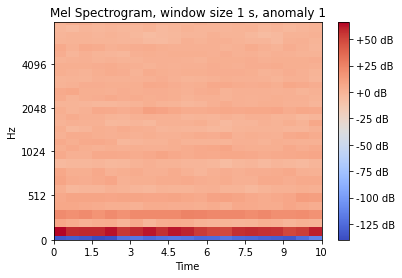

In [81]:
# Compute and plot mel spectrogram
no_file = 2
file_path = os.path.join(data_dir, df_model.iloc[no_file].file_rel_path)
fs = df_machine.iloc[no_file].fs_Hz
window = 1
n_mels = 32
overlap = 0.5
mel_spect, mel_spect_db, mfcc, params = get_mel_spectrogram(file_path, window=window, overlap=overlap, 
                                                            n_mels=n_mels, machine=df_model['machine'][0]) 

# print(params)

print(f"Size of mel_spect: {mel_spect.shape}, total number of points: {mel_spect.size}")
librosa.display.specshow(mfcc, sr=fs, hop_length=params['hop_length'], x_axis='time', y_axis='mel');

plt.title(f"Mel Spectrogram, window size {params['window']} s, anomaly {df_machine.iloc[no_file].anomaly}");
plt.colorbar(format='%+2.0f dB')

In [82]:
no_windows = mel_spect.shape[1]
n_mels = params['n_mels']
window = params['window']
overlap = params['overlap']
[(n+0.5)*window - n*overlap*window for n in np.arange(0,no_windows)]

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5]

array([  91.796875 ,  182.6171875,  274.4140625,  365.234375 ,
        457.03125  ,  548.828125 ,  639.6484375,  731.4453125,
        822.265625 ,  914.0625   , 1005.859375 , 1105.46875  ,
       1213.8671875, 1333.984375 , 1465.8203125, 1611.328125 ,
       1770.5078125, 1945.3125   , 2137.6953125, 2348.6328125,
       2581.0546875, 2835.9375   , 3117.1875   , 3424.8046875,
       3763.671875 , 4135.7421875, 4543.9453125, 4993.1640625,
       5487.3046875, 6029.296875 , 6625.       , 7280.2734375])

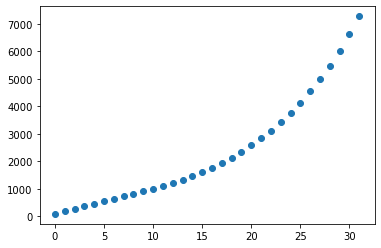

In [83]:
# Centers of mel frequency bands
plt.scatter(range(len(params['mel_center_freq'])), params['mel_center_freq'])
params['mel_center_freq']

In [84]:
window = 1
n_mels = 32
overlap = 0.5

X, y, Xy, ft_grid_names, params = get_melspec_features_from_files(data_dir, df_model, window, overlap=overlap, n_mels=n_mels)

Calculation at 0.00%
Calculation at 4.41%
Calculation at 8.81%
Calculation at 13.22%
Calculation at 17.62%
Calculation at 22.03%
Calculation at 26.43%
Calculation at 30.84%
Calculation at 35.24%
Calculation at 39.65%
Calculation at 44.05%
Calculation at 48.46%
Calculation at 52.86%
Calculation at 57.27%
Calculation at 61.67%
Calculation at 66.08%
Calculation at 70.48%
Calculation at 74.89%
Calculation at 79.30%
Calculation at 83.70%
Calculation at 88.11%
Calculation at 92.51%
Calculation at 96.92%


In [85]:
# Normalization
minval = X.min()
maxval = X.max()
X = (X-minval)/(maxval-minval)

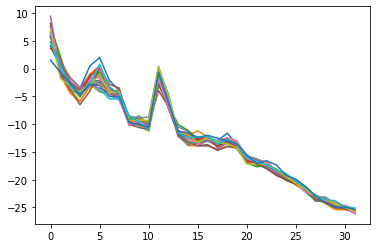

In [86]:
no_sample = 20
sample = Xy.iloc[no_sample, :-1].to_numpy().reshape((params['n_mels'], params['no_windows']))
plt.plot(sample)
plt.show()

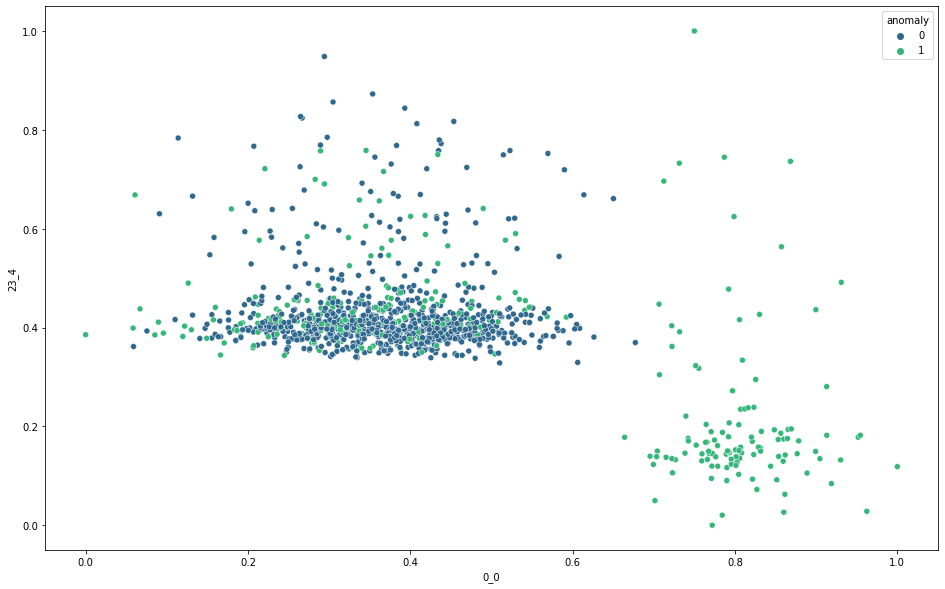

In [88]:
# Visualize data
plot_columns = {'x': '0_0',
                'y': '23_4'}
df_toplot = X.copy()
df_toplot = df_toplot.join(y)
df_toplot = df_toplot.join(df_model.anomaly)
ind_x = list(df_toplot.columns.values).index(plot_columns['x'])
ind_y = list(df_toplot.columns.values).index(plot_columns['y'])

plt.figure(figsize=(16,10))
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='anomaly',
                   palette='viridis')
plt.show()

In [89]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [90]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

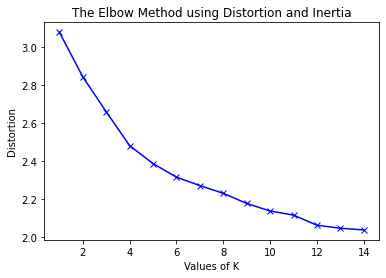

In [91]:
plt.plot(K, distortions, 'bx-')
#plt.plot(K, inertias, 'rx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion and Inertia')
plt.show()

In [96]:
# fit a kmeans object to the dataset
no_clusters = 5
kmeans = KMeans(n_clusters=no_clusters, init='k-means++').fit(X)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
try:
    df_model = df_model.join(cluster_labels)
except:
    df_model['cluster'] = cluster_labels

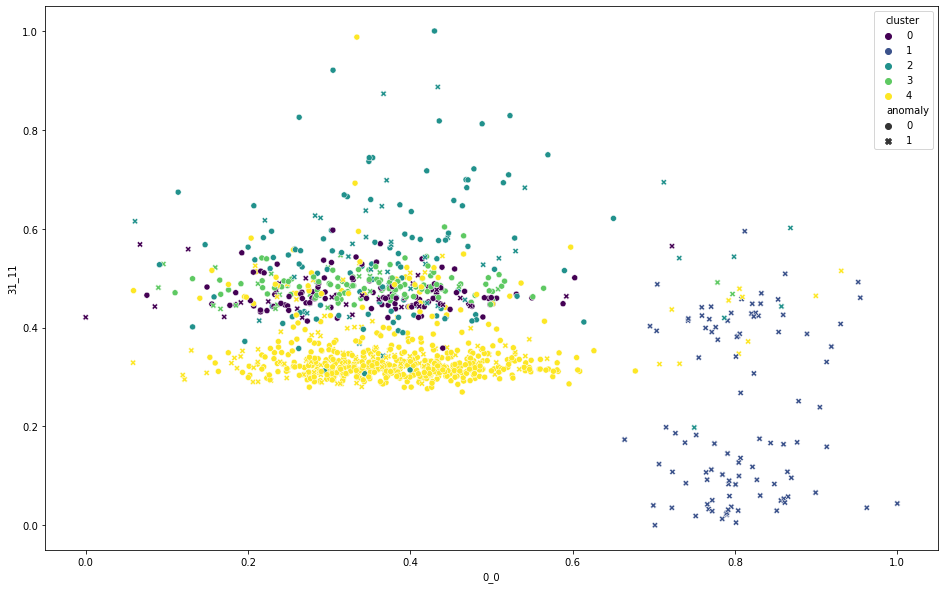

In [97]:
# visualise your clusters here (take a look at the pandas scatter_matrix or seaborn's pairplot method)
plot_columns = {'x': '0_0',
                'y': '31_11'}
df_toplot = X.copy()
df_toplot = df_toplot.join(y)
df_toplot = df_toplot.join(df_model.cluster)
df_toplot = df_toplot.join(df_model.anomaly)
ind_x = list(df_toplot.columns.values).index(plot_columns['x'])
ind_y = list(df_toplot.columns.values).index(plot_columns['y'])

plt.figure(figsize=(16,10))
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='cluster', style='anomaly',
                   palette='viridis')
#p = plt.scatter(cluster_centers[:,ind_x], cluster_centers[:,ind_y], s=250, marker='s', edgecolors='k',
#            c=s._colors)
#p = plt.scatter(df_toplot[plot_columns['x']], df_toplot[plot_columns['y']], s=250, marker='*', edgecolors='k',
#            c=s._colors)
plt.show()

<Figure size 1152x720 with 0 Axes>

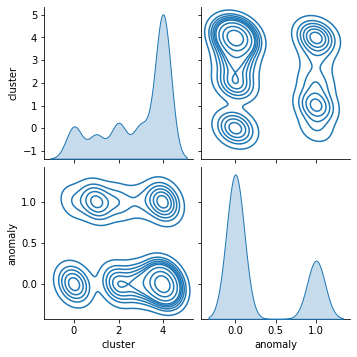

In [99]:
plt.figure(figsize=(16,10))
s = sns.pairplot(data=df_model[['cluster','anomaly']],
                   palette='viridis', kind="kde")

In [101]:
# rand_score for abnormal vs others
labels_true = df_model.anomaly
labels_pred = df_model.cluster
labels_pred = [1 if elem==1 else 0 for elem in labels_pred]
metrics.adjusted_rand_score(labels_true, labels_pred)

0.2696971439736283

In [37]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=1, metric='euclidean', ).fit(X.to_numpy())
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
np.unique(labels)

array([-1], dtype=int64)

In [ ]:
# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=8, init='k-means++').fit(X)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
df_machine['cluster'] = cluster_labels


In [ ]:
# visualise your clusters here (take a look at the pandas scatter_matrix or seaborn's pairplot method)
plot_columns = {'x': '10_0',
                'y': '16_4'}
df_toplot = X.copy()
df_toplot = df_toplot.join(y)
df_toplot = df_toplot.join(df_machine.model)
df_toplot = df_toplot.join(df_machine.cluster)
df_toplot = df_toplot.join(df_machine.anomaly)
ind_x = list(df_toplot.columns.values).index(plot_columns['x'])
ind_y = list(df_toplot.columns.values).index(plot_columns['y'])

plt.figure(figsize=(16,10))
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='cluster', style='anomaly',
                   palette='viridis')
#p = plt.scatter(cluster_centers[:,ind_x], cluster_centers[:,ind_y], s=250, marker='s', edgecolors='k',
#            c=s._colors)
#p = plt.scatter(df_toplot[plot_columns['x']], df_toplot[plot_columns['y']], s=250, marker='*', edgecolors='k',
#            c=s._colors)
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
s = sns.pairplot(data=df_machine[['model','cluster','anomaly']],
                   palette='viridis', kind="kde")

In [ ]:
# Add labels for training and test
df_machine = add_train_test_labels_to_dataframe(df_machine, no_seed=12)

In [ ]:
# Get training and test samples
X_train, X_test, y_train, y_test = get_train_test_data(X, y, df_machine)

In [ ]:
# Histogram of features
plt.hist(X_train.iloc[:, 0])
plt.show()

In [ ]:
# One class svm 
gamma = 0.01
nu = 0.5
prctle = 2
out_class = train_test_one_class_svm(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy(), 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

In [ ]:
cm_plot = out_class[3]
df_cm = pd.DataFrame(cm_plot, range(cm_plot.shape[0]), range(cm_plot.shape[1]))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

print(out_class[1])

In [ ]:
ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ran_prctl = range(1,15)
nu = 0.5
# Initialize arrays
out_metrics_gn = {}
out_metrics_gn['acc'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['precision']  = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['recall'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['TPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_gn['FPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl):
        print(gamma, prctle)
        
        out_class = train_test_one_class_svm(X_train, X_test, y_train, y_test, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
        # return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params
        
        out_metrics = out_class[5]
        out_metrics_gn['acc'][id_p, id_g] = out_metrics['acc']
        out_metrics_gn['precision'][id_p, id_g] = out_metrics['precision']
        out_metrics_gn['recall'][id_p, id_g] = out_metrics['recall']
        out_metrics_gn['TPR'][id_p, id_g] = out_metrics['TPR']
        out_metrics_gn['FPR'][id_p, id_g] = out_metrics['FPR']
        

In [ ]:
len(ran_gamma)

In [ ]:
out_metrics_gn['recall'][:, 7]

In [ ]:
out_metrics_gn['precision'][:, 7]

In [ ]:
out_metrics_gn['recall'].shape

In [ ]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g<8):
        plt.plot(out_metrics_gn['recall'][:, id_g], out_metrics_gn['precision'][:, id_g])
        plt.xlim([0, 1])
        plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g==5):
        print(gamma)
        plt.plot(out_metrics_gn['recall'][:, id_g], out_metrics_gn['precision'][:, id_g])
        plt.xlim([0, 1])
        plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
plt.show()

In [ ]:
out_metrics_gn['precision'].shape

In [ ]:
id_p = 12
id_g = 5
print(ran_prctl[id_p])
print("precision: ", out_metrics_gn['precision'][id_p, id_g])
print("recall: ", out_metrics_gn['recall'][id_p, id_g])

In [ ]:
# Select all abnormal samples as test, equal number of normal also in test, rest in training
df_machine_all = df[df.machine=='fan']

window = 0.5
n_mels = 64
overlap = 0.25

X_all, y_all, params_all = get_melspec_features_from_files(data_dir, df_machine_all, window, n_mels, overlap)

# Add labels for training and test
df_machine_all = add_train_test_labels_to_dataframe(df_machine_all, no_seed=30)

# Get training and test samples
X_train_all, X_test_all, y_train_all, y_test_all = get_train_test_data(X_all, y_all, df_machine_all)

# One class svm 
id_p = 12
id_g = 5
prctl = ran_prctl[id_p]
gamma = ran_gamma[id_g]
nu = 0.5
out_class_selected = train_test_one_class_svm(X_train, X_test, y_train, y_test, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

In [ ]:
id_g_selected = 5
ran_gamma_selected = [ran_gamma[id_g_selected]]
nu = 0.5
# Initialize arrays
out_metrics_all_gn = {}
out_metrics_all_gn['acc'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['precision']  = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['recall'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['TPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['FPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma_selected):
    for id_p, prctle in enumerate(ran_prctl):
        
        out_class = train_test_one_class_svm(X_train_all, X_test_all, y_train_all, y_test_all, 
                                     kernel='rbf', gamma=0.001, nu=0.5, prctle=2, normalize="min-max")
        # return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params
        
        out_metrics = out_class[5]
        out_metrics_all_gn['acc'][id_p, id_g] = out_metrics['acc']
        out_metrics_all_gn['precision'][id_p, id_g] = out_metrics['precision']
        out_metrics_all_gn['recall'][id_p, id_g] = out_metrics['recall']
        out_metrics_all_gn['TPR'][id_p, id_g] = out_metrics['TPR']
        out_metrics_all_gn['FPR'][id_p, id_g] = out_metrics['FPR']
        

In [ ]:
ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ran_prctl_selected = 7 # range(0,15)
nu = 0.5
# Initialize arrays
out_metrics_all_gn = {}
out_metrics_all_gn['acc'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['precision']  = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['recall'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['TPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
out_metrics_all_gn['FPR'] = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl_selected):
        
        out_class = train_test_one_class_svm(X_train_all, X_test_all, y_train_all, y_test_all, 
                                     kernel='rbf', gamma=0.001, nu=0.5, prctle=2, normalize="min-max")
        # return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params
        
        out_metrics = out_class[5]
        out_metrics_all_gn['acc'][id_p, id_g] = out_metrics['acc']
        out_metrics_all_gn['precision'][id_p, id_g] = out_metrics['precision']
        out_metrics_all_gn['recall'][id_p, id_g] = out_metrics['recall']
        out_metrics_all_gn['TPR'][id_p, id_g] = out_metrics['TPR']
        out_metrics_all_gn['FPR'][id_p, id_g] = out_metrics['FPR']
        

In [ ]:
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl_selected):
        if(id_g==id_g_selected):
            print(gamma)
            plt.plot(out_metrics_all_gn['recall'][:, id_g], out_metrics_all_gn['precision'][:, id_g])
            plt.xlim([0, 1])
            plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
# Metrics for the previously chosen gamma and prctle
id_p_selected = 3
prctl = ran_prctle[id_p_selected]
gamma = ran_gamma[id_g_selected]
out_class = train_test_one_class_svm(X_train_all, X_test_all, y_train_all, y_test_all, 
                                     kernel='rbf', gamma=gamma, nu=nu, prctle=prctle, normalize="min-max")
# return OneClassSVM, report, cm_train, cm_test, out_metrics_train, out_metrics_test, params

In [ ]:
cm_test

In [ ]:
out_metrics_test_all

In [ ]:
cm_train

In [ ]:
out_metrics_train_all